### Bert loading

In [20]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [21]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.load_state_dict(torch.load("/kaggle/working/bert_sst2.pth"))

model.eval()

tokenizer = BertTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() 

print("Model loaded successfully!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


Integrated Gradients is an attribution method that aims to explain the relationship between a model's predictions and its inputs. It assigns an "importance score" to each feature of the input (in our case, each token) regarding a specific prediction.

The main idea is

How much did a particular token contribute to the final prediction, compared to a neutral baseline?

Baseline==A neutral or "information-less" input , space toeksn , end of sentence ect

Gradients==The gradient of the model's output with respect to the input

Integration==we dotn pick a random starting point to inspect the gradient we sum it uo from each step 

In [22]:
# class0==neg
#class 1==pos

## Out testing tokens

In [23]:
#we tokenize the input test
sentence ="This movie is good"
inputs = tokenizer(sentence, return_tensors="pt") 
input_ids = inputs["input_ids"]
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)
input_ids  # we convert each word to the toekn id 

tensor([[ 101, 2023, 3185, 2003, 2204,  102]], device='cuda:0')

In [24]:
#we get embedding of each token
embeddings = model.bert.embeddings.word_embeddings(input_ids)
embeddings = embeddings.to(device)
print(embeddings)
print(embeddings.shape)

tensor([[[ 0.0137, -0.0264, -0.0237,  ...,  0.0090,  0.0069,  0.0149],
         [-0.0567,  0.0154, -0.0050,  ..., -0.0041,  0.0009,  0.0094],
         [-0.0029, -0.0067, -0.0256,  ..., -0.0223,  0.0064, -0.0523],
         [-0.0356, -0.0254, -0.0262,  ...,  0.0028, -0.0015,  0.0267],
         [ 0.0022, -0.0095, -0.0367,  ..., -0.0692, -0.0799, -0.0862],
         [-0.0146, -0.0098,  0.0065,  ..., -0.0246,  0.0044, -0.0017]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
torch.Size([1, 6, 768])


## we define a baseline

In [19]:
baseline = torch.zeros_like(embeddings)
#what we will consider as neurtral tokens 
#HYPOTHISIS , what i think logically this should be the tokens such as "is", "that"  but what we found with gradient x input method is that those toeksn had
#the strongest contribution to classifying the sentence -This movie is good - to a positive meaning

## the interpolation for Integrated Gradients

so , to explain this concept , the idea is we wont jump from the baseline to the final embedding , we define points of information extraction for each step:

and when we say step we mean 
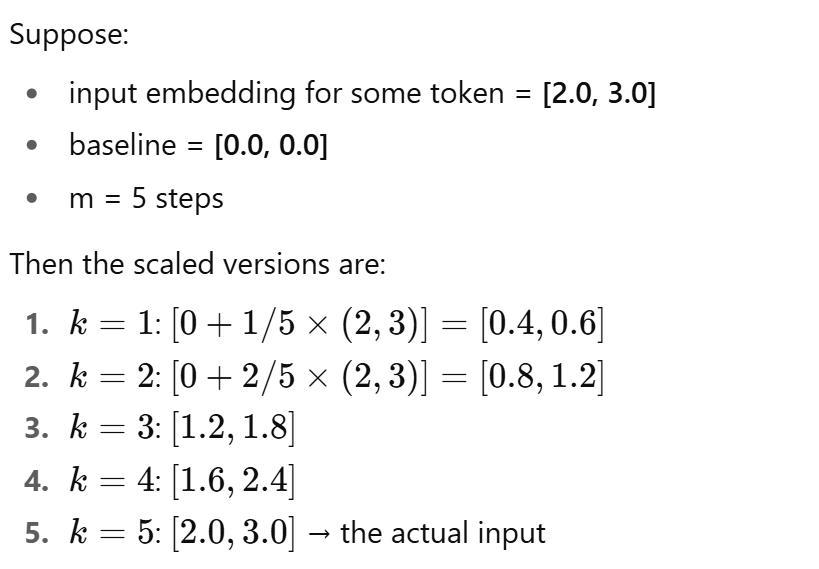

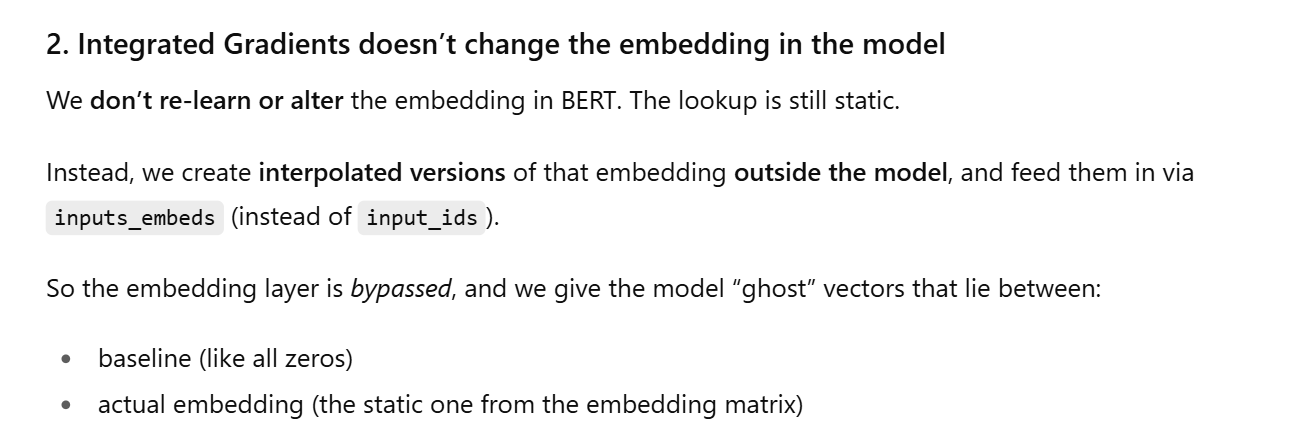


## Generate scaled inputs

In [25]:
m_steps = 50
scaled_inputs = [baseline + (float(k)/m_steps) * (embeddings - baseline) for k in range(1, m_steps+1)]


## Compute gradients along the path
for each scaled input we do a forward pass -----------x  pick target logits aka a class ---------------x  backprop to get gradients w.r.t embeddings

In [26]:
all_grads = []
for scaled in scaled_inputs:
    scaled = scaled.clone().detach().requires_grad_(True)

    outputs = model(inputs_embeds=scaled, attention_mask=inputs["attention_mask"])
    score = outputs.logits[0, 1]  # positive class
    score.backward(retain_graph=True)

    grads = scaled.grad.detach()
    all_grads.append(grads)


## Average gradients

In [27]:
avg_grads = torch.mean(torch.stack(all_grads), dim=0)

## Compute Integrated Gradients

In [28]:
integrated_grads = (embeddings - baseline) * avg_grads


## Reduce to scalar per token

In [30]:
token_importance = integrated_grads.sum(dim=-1)  
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

print(list(zip(tokens, token_importance[0].cpu().detach().numpy())))

[('[CLS]', -0.5020745), ('this', -1.5601535), ('movie', 0.32995528), ('is', 0.42328382), ('good', 4.505523), ('[SEP]', -8.264779)]


the maginture / absolute value is teh importance of that token , the sign define are we pushing in that class or not ,here the class we are working on is the positive 
which explain why good , has the highest importance ! aaaaaaaand unlike the results that gradient xinput gave that didnt make sense where "is" had higher contribution that good , here the results make more sense

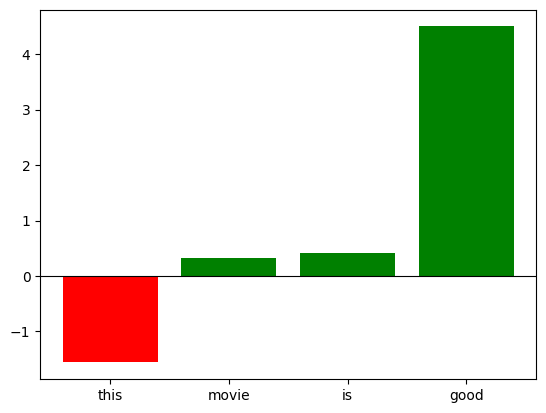

In [31]:

tokens = ["this", "movie", "is", "good"]
scores = [-1.56, 0.33, 0.42, 4.5]

plt.bar(tokens, scores, color=["red" if s < 0 else "green" for s in scores])
plt.axhline(0, color="black", linewidth=0.8)
plt.show()
